In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import multitask_dep as mt
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
encoding_type = 'absolute'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab,word_to_index) 

In [7]:
convai_train_dataset =rrnn.DatasetMultiTaskRRNN(convai_train_token,tasks,eval=False,deps=True)

In [8]:
convai_val_dataset = rrnn.DatasetMultiTaskRRNN(convai_val_token,tasks,eval=False,deps=True)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab,word_to_index) 


md_dataset  = rrnn.DatasetMultiTaskRRNN(md_tokenized,tasks,eval=True,deps=True)

# Creación dataloaders

In [11]:
dl_train =  DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep_multi)
dl_val = DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep_multi)
dl_eval  = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep_multi)

# Pruebas hiperparámetros 1

In [12]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

In [13]:
num_epochs = 100
learning_rate = 5e-5

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0758122143429745 	 Validation loss: 2.079364029027648 	 
  1%|          | 574/57400 [00:07<11:31, 82.21it/s]
Epoch 2 	 Training loss: 2.073249633303918 	 Validation loss: 2.0768904564744335 	 
  2%|▏         | 1148/57400 [00:14<10:53, 86.08it/s]
Epoch 3 	 Training loss: 2.0679840871265958 	 Validation loss: 2.078787811731888 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:22<10:49, 85.66it/s]
Epoch 4 	 Training loss: 2.0659926240867854 	 Validation loss: 2.071693497189021 	 
  4%|▍         | 2296/57400 [00:29<10:42, 85.80it/s]
Epoch 5 	 Training loss: 2.06346247088203 	 Validation loss: 2.066026065309169 	 
  5%|▌         | 2870/57400 [00:36<10:41, 84.99it/s]
Epoch 6 	 Training loss: 2.0621041711614523 	 Validation loss: 2.0694443371336337 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:43<10:25, 86.25it/s]
Epoch 7 	 Training loss: 2.0605738491131453 	 Validation loss: 2.0650861344095004 	 
  7%|▋         | 4018/57400 [00:51<10

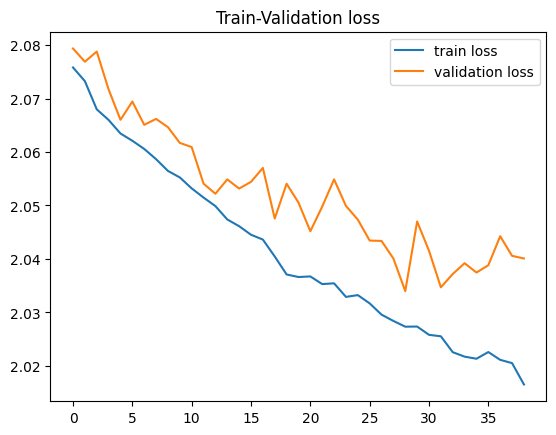

In [14]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_multi_{encoding_type}_v1_1'
optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [15]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Evaluación del modelo
{'to': {'recall': 0.5454545454545454, 'precision': 0.5454545454545454, 'f1': 0.5454545454545454, 'accuracy': 0.5454545454545454}, 'as': {'recall': 0.6179921773142112, 'precision': 0.6179921773142112, 'f1': 0.6179921773142112, 'accuracy': 0.6179921773142112}, 'about': {'recall': 0.6237244897959183, 'precision': 0.6237244897959183, 'f1': 0.6237244897959183, 'accuracy': 0.6237244897959183}} 

Evaluación en etiquetas male
{'to': {'recall': 0.5547445255474452, 'precision': 0.5547445255474452, 'f1': 0.5547445255474452, 'accuracy': 0.5547445255474452}, 'as': {'recall': 0.5732323232323232, 'precision': 0.5732323232323232, 'f1': 0.5732323232323232, 'accuracy': 0.5732323232323232}, 'about': {'recall': 0.6354166666666666, 'precision': 0.6354166666666666, 'f1': 0.6354166666666666, 'accuracy': 0.6354166666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.5354330708661418, 'precision': 0.5354330708661418, 'f1': 0.5354330708661418, 'accuracy': 0.5354330708661418}, 'a

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.075946655007605 	 Validation loss: 2.079617427567304 	 
  1%|          | 574/57400 [00:07<11:05, 85.44it/s]
Epoch 2 	 Training loss: 2.0742416539674022 	 Validation loss: 2.0780910839468745 	 
  2%|▏         | 1148/57400 [00:14<10:53, 86.05it/s]
Epoch 3 	 Training loss: 2.071497703263153 	 Validation loss: 2.0778039835267146 	 
  3%|▎         | 1722/57400 [00:21<10:40, 86.91it/s]
Epoch 4 	 Training loss: 2.067506289232899 	 Validation loss: 2.073381880582389 	 
  4%|▍         | 2296/57400 [00:28<10:44, 85.44it/s]
Epoch 5 	 Training loss: 2.0654858886572542 	 Validation loss: 2.0700204049126576 	 
  5%|▌         | 2870/57400 [00:36<10:59, 82.67it/s]
Epoch 6 	 Training loss: 2.063453387715675 	 Validation loss: 2.0780818866471114 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:43<10:37, 84.62it/s]
Epoch 7 	 Training loss: 2.0601573459778098 	 Validation loss: 2.071588120218051 	 

2 epoch without improvement
  7%|▋         | 4018/57400 [00:50<10

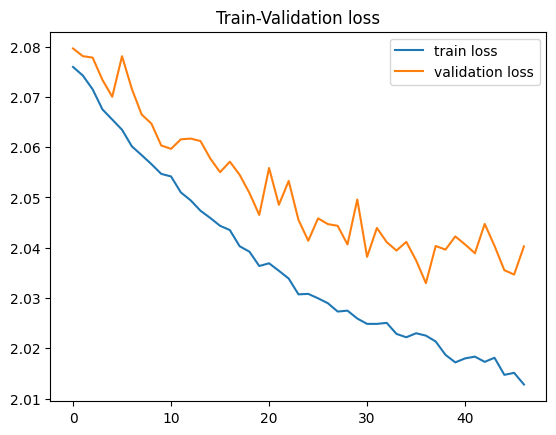

In [16]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

save_path=f'm1_rrnn_multi_{encoding_type}_v1_2'
optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [17]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Evaluación del modelo
{'to': {'recall': 0.5707070707070707, 'precision': 0.5707070707070707, 'f1': 0.5707070707070707, 'accuracy': 0.5707070707070707}, 'as': {'recall': 0.5788787483702738, 'precision': 0.5788787483702738, 'f1': 0.5788787483702738, 'accuracy': 0.5788787483702738}, 'about': {'recall': 0.6352040816326531, 'precision': 0.6352040816326531, 'f1': 0.6352040816326531, 'accuracy': 0.6352040816326531}} 

Evaluación en etiquetas male
{'to': {'recall': 0.6472019464720195, 'precision': 0.6472019464720195, 'f1': 0.6472019464720195, 'accuracy': 0.6472019464720195}, 'as': {'recall': 0.601010101010101, 'precision': 0.601010101010101, 'f1': 0.601010101010101, 'accuracy': 0.601010101010101}, 'about': {'recall': 0.7135416666666666, 'precision': 0.7135416666666666, 'f1': 0.7135416666666666, 'accuracy': 0.7135416666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.4881889763779528, 'precision': 0.4881889763779528, 'f1': 0.4881889763779528, 'accuracy': 0.4881889763779528}, 'as': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0754290827475357 	 Validation loss: 2.080240585036197 	 
  1%|          | 574/57400 [00:07<11:06, 85.28it/s]
Epoch 2 	 Training loss: 2.072712894516124 	 Validation loss: 2.0772735991720426 	 
  2%|▏         | 1148/57400 [00:14<11:02, 84.96it/s]
Epoch 3 	 Training loss: 2.0694096013644017 	 Validation loss: 2.073584944514905 	 
  3%|▎         | 1722/57400 [00:21<10:45, 86.25it/s]
Epoch 4 	 Training loss: 2.065994960505788 	 Validation loss: 2.069986496941518 	 
  4%|▍         | 2296/57400 [00:29<10:41, 85.86it/s]
Epoch 5 	 Training loss: 2.0626837276830905 	 Validation loss: 2.0706510786282815 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:36<10:44, 84.67it/s]
Epoch 6 	 Training loss: 2.060724945018516 	 Validation loss: 2.0735639313520013 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:43<10:19, 87.13it/s]
Epoch 7 	 Training loss: 2.0598910764534715 	 Validation loss: 2.0647443714788403 	 
  7%|▋         | 4018/57400 [00:50<1

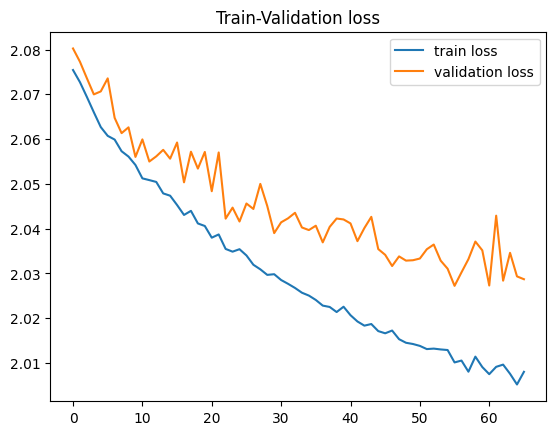

In [18]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_multi_{encoding_type}_v1_3'
optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [19]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Evaluación del modelo
{'to': {'recall': 0.5669191919191919, 'precision': 0.5669191919191919, 'f1': 0.5669191919191919, 'accuracy': 0.5669191919191919}, 'as': {'recall': 0.5827900912646675, 'precision': 0.5827900912646675, 'f1': 0.5827900912646675, 'accuracy': 0.5827900912646675}, 'about': {'recall': 0.6313775510204082, 'precision': 0.6313775510204082, 'f1': 0.6313775510204082, 'accuracy': 0.6313775510204082}} 

Evaluación en etiquetas male
{'to': {'recall': 0.5328467153284672, 'precision': 0.5328467153284672, 'f1': 0.5328467153284672, 'accuracy': 0.5328467153284672}, 'as': {'recall': 0.5075757575757576, 'precision': 0.5075757575757576, 'f1': 0.5075757575757576, 'accuracy': 0.5075757575757576}, 'about': {'recall': 0.6640625, 'precision': 0.6640625, 'f1': 0.6640625, 'accuracy': 0.6640625}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6036745406824147, 'precision': 0.6036745406824147, 'f1': 0.6036745406824147, 'accuracy': 0.6036745406824147}, 'as': {'recall': 0.6630727762803235, '

In [20]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6301020408163265, 'precision': 0.6301020408163265, 'f1': 0.6301020408163265, 'accuracy': 0.6301020408163265}
Métricas etiqueta male: {'recall': 0.6710069444444444, 'precision': 0.6710069444444444, 'f1': 0.6710069444444444, 'accuracy': 0.6710069444444444}
Métricas etiqueta female:  {'recall': 0.5908333333333333, 'precision': 0.5908333333333333, 'f1': 0.5908333333333333, 'accuracy': 0.5908333333333333}

 to
Resultado global: {'recall': 0.561026936026936, 'precision': 0.561026936026936, 'f1': 0.561026936026936, 'accuracy': 0.561026936026936}
Métricas etiqueta male: {'recall': 0.578264395782644, 'precision': 0.578264395782644, 'f1': 0.578264395782644, 'accuracy': 0.578264395782644}
Métricas etiqueta female:  {'recall': 0.5424321959755031, 'precision': 0.5424321959755031, 'f1': 0.5424321959755031, 'accuracy': 0.5424321959755031}

 as
Resultado global: {'recall': 0.5932203389830508, 'precision': 0.5932203389830508, 'f1': 0.593220338